# Sesión 9 - Implementación de algoritmos PPO

> En la presente sesión, se va a desarrollar la **implementación**  algoritmos avandos dentro de la familia de **Policy Gradients (PG)** En concreto, se va a implementar la versión básica de **Advantadge Actor-Critic (AC)** (sin multiproceso), y el algoritmo **Proximal Policy Optimization (PPO)**. La segunda versión incorpora ciertos avances con respecto al algoritmo PG. En concreto, trata de solventar el problema de la actualización de políticas incoherentes, a partir de la ponderación de los gradientes por un ratio de la evolución de la policy. La implementación será realizada utilizando la librería **pytorch**. Finalmente, se realizarán visualizaciones de KPIs del proceso de entrenamiento, con tal de analizar su convergencia, y su utilidad con respecto al PG básico





---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.



---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda update --all
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```




---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [ ]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/VIU/08_AR_MIAR/sesiones_practicas/sesion_practica_3"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [ ]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

---
### 1.4. Instalar librerías necesarias


In [ ]:
if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0

---
### 1.5.Acerca de las librerías para RL

Librería para trabajar con nuestros entornos: gym (https://gym.openai.com/) \
Librería para trabajar con deep learning: tensorflow (https://www.tensorflow.org/) \
Librería para desarrollar soluciones de RL a alto nivel: keras-rl (https://github.com/keras-rl/keras-rl) \


---
## **PARTE 2** - *PPO*


---
### 2.1. PPO Pseudo-código

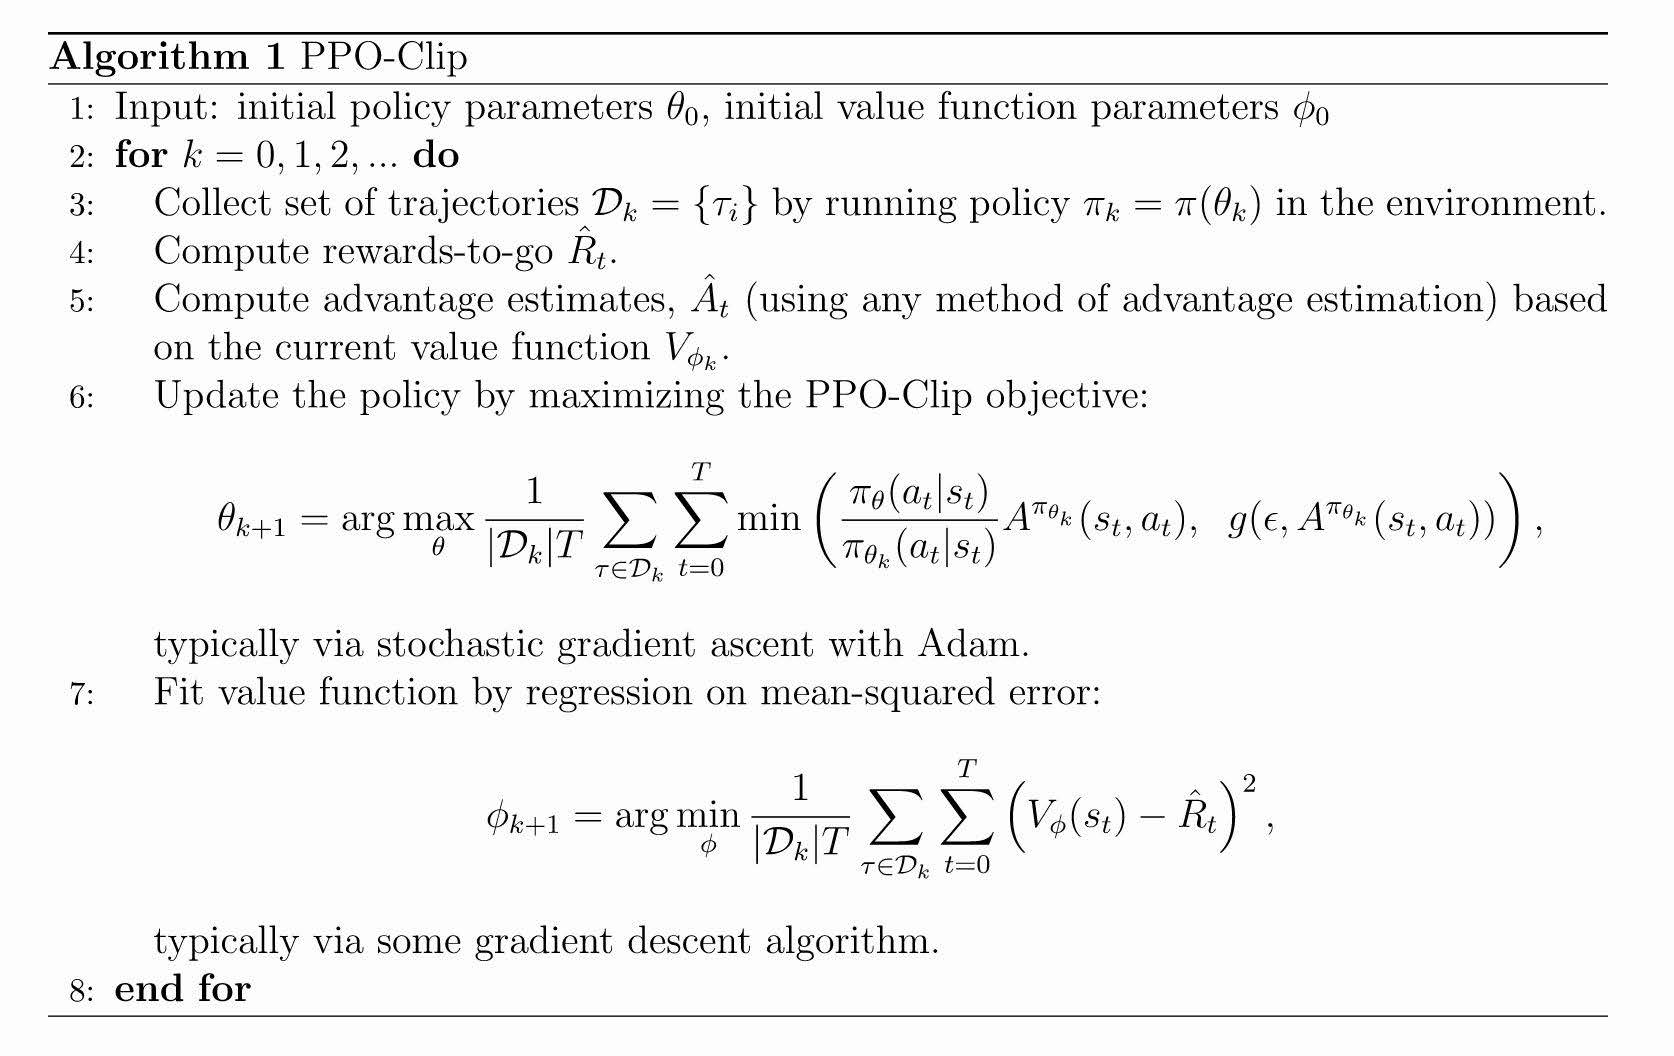

In [ ]:
from IPython import display
display.Image("images/ppo.jpg", width = 600, height = 300)

---
### 2.2. Ejemplo de *PPO* con *Pytorch*

In [ ]:
# Imports
import math
import os
import sys
import time

import numpy as np
import gym
import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.autograd import Variable

In [ ]:
# Variables
model_path = "breackout_ac.pth"
env_name = "BreakoutDeterministic-v4"

# Hyperparametros - Entrenamiento
EPISODES_TRAINING = 5000
EPISODES_TESTING = 10
GAMMA = 0.99
T = 224
ALPHA_VALUE = 0.5
EPOCHS = 10
EPSILON_CLIP = 0.1

# Hyperparametros - Preprocesado observacion-stado
HEIGHT, WIDTH = 84, 84
N_FRAMES = 4

In [ ]:
# Definir arquitectura del knowledge (CNN)
class ActorCritic(nn.Module):
  def __init__(self, number_actions=4):
    super(ActorCritic, self).__init__()

    # Definimos las capas de la red neuronal
    # 1) Base Model
    self.conv1 = nn.Conv2d(4, 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

    # 2) Proyección intermedia (Asumimos que hemos hecho flatten)
    self.fc1 = nn.Linear(7*7*64, 512) # Para más generalizable, podria usarse GAP

    # 3) Salida hibrida
    self.actor = nn.Linear(512, number_actions) # number of actions
    self.critic = nn.Linear(512, 1) # linear output of value

  def forward(self, x):

    # 1) Forward base model
    x = torch.nn.functional.relu(self.conv1(x))
    x = torch.nn.functional.relu(self.conv2(x))
    x = torch.nn.functional.relu(self.conv3(x))

    # 2) Flatten + Projection
    x = x.view(-1, 7*7*64)
    x = torch.nn.functional.relu(self.fc1(x))

    # 3) Salida hibrida
    policy = self.actor(x) # Aplicaremos softmax más adelante
    value = self.critic(x)

    return policy, value

In [ ]:
## Funciones para pre-procesado

# Pasar de rgb a nivel de gris y re-escalado
def rgb2gray_and_resize(screen, height, width):

  # RGB a gris
  screen_gray = np.array(np.dot(screen[...,:3], [0.299, 0.587, 0.114]), dtype=np.uint8)
  # pixel (1,1) -> r=10, g=20, b=30 -> gray = 10 * 0.299 + 20*0.587 + ...
  img_from_array = Image.fromarray(screen_gray)

  # Re-escalado de imagen
  img_from_array = img_from_array.resize((height, width))

  return np.array(img_from_array)

# Concatenar secuencias (window_lenght)
def update_frame_sequence(state, obs, n_frames=4, width=84, height=84):

  # Paso a nivel de gris, re-escalado, y estandarización
  obs = np.ascontiguousarray(rgb2gray_and_resize(obs, height, width), dtype=np.float32) / 255
  obs = torch.FloatTensor(obs)

  # Incorporar a buffer
  if state is None: # Inicio, no tenemos ventanas previas - repetimos obs inicial
    _state = obs.repeat(n_frames, 1).view(n_frames, width, height)
  else: # Tenemos ventanas previas, incorporamos la última ventana
    _state = state.view(n_frames, height, width)
    _state = torch.cat((_state[1:], obs.view(1, width, height)))

  return _state

# Estandarizar recompensas
def calculate_reward(reward):
  reward = np.clip(1, -1, reward)
  return reward

In [ ]:
# Entrenamiento de agente Proximal Policy Optimization (PPO):
torch.manual_seed(22) # Reproducibilidad

# Instanciamos un entorno y modelo para el proceso
env = gym.make(env_name) # Entorno
model = ActorCritic().cuda()
model.train() # en evaluacion, tendriamos que hacer: model.eval()

# Preparar optimizador
optimizer = optim.Adam(model.parameters(), lr=0.00025)

# Inicializamos primera trayectoria
obs = env.reset()
state = None
state = update_frame_sequence(state=state, obs=obs, width=WIDTH, height=HEIGHT)

# Primer bucle: episodios de entrenamiento
for i_episode in range(int(EPISODES_TRAINING)):
  done = False
  # Buffer de memoria
  states, actions, rewards, values, old_probs = [], [], [], [], []
  # Segundo bucle: recopilamos la trayectoria
  # A. Recopilar trayectoria
  for step in range(int(T)):

    # Foward de actor-critic dado el estado actual
    logits, value = model(state.unsqueeze(0).cuda())

    # Obtenemos probabilidad de acción
    prob = torch.nn.functional.softmax(logits, -1) # [0, 0.2, 0.6, 0.2]

    # Obtener la acción a realizar
    action = prob.multinomial(num_samples=1) # 2

    # Con la accion seleccionada, realizamos un step en el entorno
    obs, reward, done, info = env.step(action.item())
    reward = calculate_reward(reward)

    # Actualizamos el estado con la siguiente observacion
    state = update_frame_sequence(state=state, obs=obs, width=WIDTH, height=HEIGHT)

    # Almacenamos información en memoria
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    values.append(value)
    old_probs.append(prob)

    if done:
      obs = env.reset()
      state = None
      state = update_frame_sequence(state=state, obs=obs, width=WIDTH, height=HEIGHT)
      break

  # B. Preparar la información para la actualización de actor y crtitic

  # B.1) Recompensa en estado final
  R = torch.zeros(1, 1)
  if not done:
    _, value = model(state.unsqueeze(0).cuda())
    R = value.data
  values.append(Variable(R))

  # B.2) Computar los discount rewards
  discount_rewards = rewards.copy()
  for i in reversed(range(len(rewards))):
    # Obtenemos discount rewards para cada t
    R = rewards[i] + GAMMA * R
    discount_rewards[i] = R

  # C. Optimización de Actor y Critic dada la/las trayectorias
  for i_epoch in range(EPOCHS):

    policy_loss, value_loss = 0, 0
    for i in range(len(rewards)):

      # C.1. Calcular advantadge como factor de relevancia
      advantadge = discount_rewards[i].cuda() - values[i]

      # C.2. Obtener criterio del critic
      value_loss = value_loss + advantadge.pow(2)

      # C.3. Actualizacion del actor mediante PPO

      # Forward en actor actual
      logits, _ = model(states[i].unsqueeze(0).cuda())
      prob = torch.nn.functional.softmax(logits, -1)

      # Seleccionamos la probabilidad de accion seleccionada en la trayectoria
      prob = prob.gather(1, Variable(actions[i]).cuda())
      old_prob = old_probs[i].gather(1, Variable(actions[i]).cuda()).detach()

      # Calculamos el ratio
      r = prob/(old_prob+1e-10)

      # p1: ponderacion con función de ventaja
      p1 = r * Variable(advantadge)

      # p2: surrogate clip
      p2 = torch.clip(r, min=1-EPSILON_CLIP, max=1+EPSILON_CLIP)* Variable(advantadge)

      # ppo loss
      ppo_loss = -torch.mean(torch.minimum(p1, p2))

      # Acumular perdidas en cada step
      policy_loss = policy_loss + ppo_loss

    # Limpiamos información del modelo
    optimizer.zero_grad()
    # Calculo función perdidas combinada
    if i_epoch == 0:
      loss_fc = (policy_loss + ALPHA_VALUE*value_loss)
    else:
      loss_fc = policy_loss
    # C.4. Computar gradientes respecto a funcion de perdidas combinada
    loss_fc.backward(retain_graph=True)
    # Step en pesos - actualizar ActorCritic
    optimizer.step()

  # Printear evolución
  print("Trayectoria " + str(int(i_episode)+1) + "/" + str(int(EPISODES_TRAINING)))
  print("Numero de steps en la trayectoria: " + str(len(rewards)) + " Recompensa total del episodio: " + str(np.sum(rewards)) + " Value promedio por step: " + str(np.mean([iValue.detach().cpu().numpy() for iValue in values])))

  # Guardar los pesos del modelo
  torch.save(model.state_dict(), model_path)